# Python Installs

In [1]:
!pip install datasets
!pip install ai2-olmo
!pip install datasets transformers torch bert_score
!pip install tf-keras
!pip install torch torchvision accelerate
!pip install hf_olmo
!pip install tabulate
!pip install scikit-learn
!pip install sentence-transformers
!pip install bleurt
!pip install scipy
!pip install krippendorff


ERROR: Could not find a version that satisfies the requirement hf_olmo (from versions: none)
ERROR: No matching distribution found for hf_olmo
ERROR: Could not find a version that satisfies the requirement bleurt (from versions: none)
ERROR: No matching distribution found for bleurt


Normal install didnt work, so:

In [2]:
!pip install git+https://github.com/google-research/bleurt.git


  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-c61kpsqw
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-c61kpsqw
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456764 sha256=81b748f525f6ea51f0926b31a602b1f0d8bc2a30b871d9379f41eae358f84afe
  Stored in directory: /tmp/pip-ephem-wheel-cache-mopzgccu/wheels/30/af/34/e148007788b060e4c76e7ecf68e70c692dff0f2632e62ac454
Successfully built BLEURT


# Mount Google Drive

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Initialization and Imports

In [4]:
import numpy as np
import pandas as pd
import random
import re
import krippendorff
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

from tabulate import tabulate
from datasets import load_dataset
from bert_score import score as bert_score
from bleurt import score as bleurt_score

from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score





# Load Models and Tokenizers

In [5]:
# Paths to fine-tuned T5, LLaMA, and DeBERTa models
t5_model_path = "/content/drive/My Drive/fine_tuned_flan_t5_base"
llama_model_path = "/content/drive/My Drive/meta_llama_2-7b-hf"
deberta_model_path = "/content/drive/My Drive/fine_tuned_deberta_regression"
bleurt_checkpoint = "/content/drive/My Drive/bleurt-large-512"

# Initialize T5 model and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_path)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_path).to('cuda')

# Initialize LLaMA model and tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_path)
llama_model = AutoModelForCausalLM.from_pretrained(
    llama_model_path,
    torch_dtype=torch.float16,

).to('cuda')
llama_tokenizer.pad_token = llama_tokenizer.eos_token  # Ensure tokenizer compatibility

# Initialize DeBERTa model and tokenizer for regression
deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_model_path)
deberta_model = AutoModelForSequenceClassification.from_pretrained(deberta_model_path).to('cuda')
deberta_model.eval()  # Set model to evaluation mode

# Initialize BLEURT scorer
bleurt_scorer = bleurt_score.BleurtScorer(bleurt_checkpoint)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Load Dataset and Preprocessing

In [6]:
# Load the ACORN dataset and slice the last entries
data = load_dataset("anab/ACORN", split="train")[-500:]

# Load a sentence embedding model for similarity comparison
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.16k [00:00<?, ?B/s]

ACORN.jsonl:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3500 [00:00<?, ? examples/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Define Helper Functions

Flan-T5 Explanation Generation

In [7]:
# Function to generate explanation using Flan-T5
def generate_explanation_t5(question, correct_choice):
    input_text = f"Question: {question} Answer: {correct_choice} Explain why:"
    inputs = t5_tokenizer(input_text, return_tensors="pt").to('cuda')
    outputs = t5_model.generate(**inputs, max_length=100)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


Few-Shot Example Selection

In [9]:
# Function to select few-shot examples for LLaMA
def select_few_shot_examples(data, num_examples=5):
    samples = random.sample(list(data), num_examples)
    few_shot_examples = [
        {
            "question": entry["question"],
            "correct_choice": entry["choices"][entry["label"]],
            "explanation": entry["explanation"]
        }
        for entry in samples
    ]
    return few_shot_examples


Prompt Creation for Few-Shot Learning

In [8]:
# Function to create prompt for few-shot learning for LLaMA
def create_prompt(question, correct_choice, few_shot_examples):
    prompt = ""
    for example in few_shot_examples:
        prompt += (
            f"Question: {example['question']}\n"
            f"Correct Choice: {example['correct_choice']}\n"
            f"Explanation: {example['explanation']}\n\n"
        )
    prompt += (
        f"Question: {question}\n"
        f"Correct Choice: {correct_choice}\n"
        f"Explanation:"
    )
    return prompt


Predict Ratings

In [10]:
# Function to predict ratings using DeBERTa
def predict_ratings(explanation):
    inputs = deberta_tokenizer(explanation, return_tensors="pt", truncation=True, padding=True, max_length=128).to('cuda')

    with torch.no_grad():
        outputs = deberta_model(**inputs)
        predictions = outputs.logits.squeeze(0)  # Get model outputs as tensor

        # Ensure predictions are between 0 and 4
        predictions = torch.clamp(predictions, min=0, max=4).tolist()

    return {
        "supports": round(predictions[0]),
        "overall": round(predictions[1]),
        "well_written": round(predictions[2]),
        "related": round(predictions[3]),
        "factual": round(predictions[4]),
        "new_info": round(predictions[5]),
        "unnecessary_info": round(predictions[6]),
        "contrastive": round(predictions[7]),
    }


Bertscore & Bleurt

In [11]:
# Function to compute BERTScore
def compute_bertscore(candidate, reference):
    P, R, F1 = bert_score([candidate], [reference], lang="en")
    return F1[0].item()  # Return F1 score for BERTScore

# Function to compute BLEURT score
def compute_bleurt(candidate, reference):
    scores = bleurt_scorer.score(references=[reference], candidates=[candidate])
    return scores[0]  # Return BLEURT score

# Select Data for Evaluation

Restructure Data for correct usage

In [12]:
restructured_data = [
    {
        key: data[key][i]
        for key in data.keys()
    }
    for i in range(len(data['id']))  # Assuming all lists are of the same length
]

Selecting Amount of Samples & Few Shot Examples

In [13]:
# Select few-shot examples for LLaMA
few_shot_examples = select_few_shot_examples(restructured_data, num_examples=5)

# Select entries for evaluation
last_samples = restructured_data[-500:]

# Evaluate Model Performance

Ignore Warnings

In [14]:
from transformers import logging as transformers_logging
import warnings  # Importiere das warnings-Modul

transformers_logging.set_verbosity_error()

warnings.filterwarnings(
    "ignore",
    message=r".*Some weights of .* were not initialized from the model checkpoint.*",
    category=UserWarning,
)


Evaluating with 1 few-shot examples...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Evaluating with 3 few-shot examples...
Evaluating with 5 few-shot examples...


Evaluating with 7 few-shot examples...


Evaluating with 10 few-shot examples...


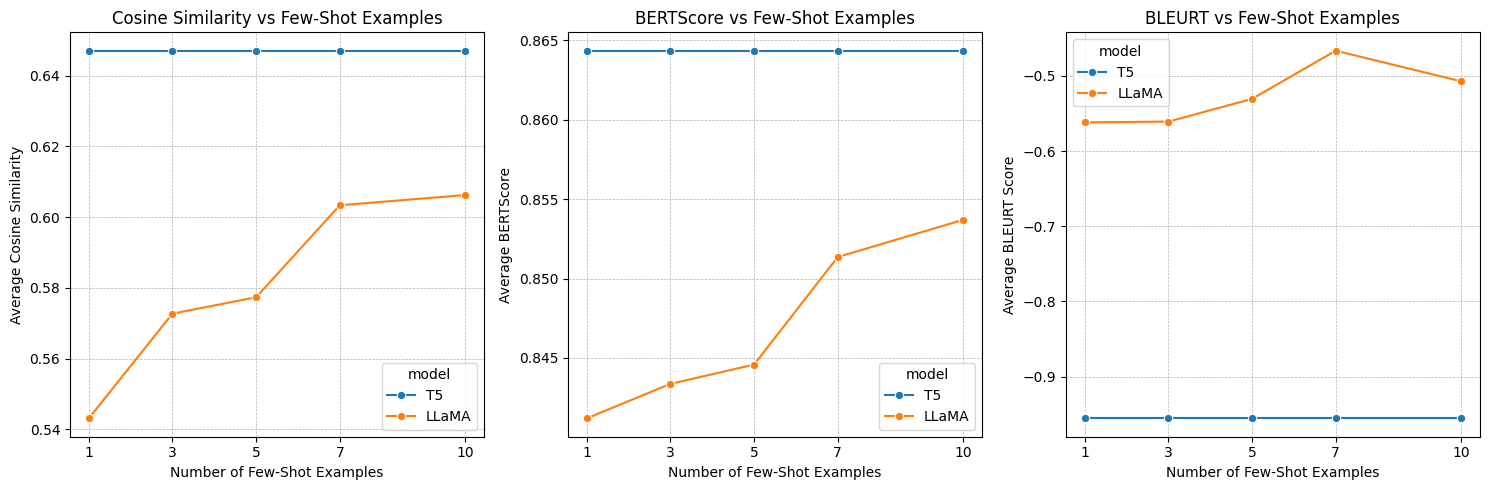


Results have been saved to 'benchmark_results.csv'


In [15]:
import numpy as np

# Define different few-shot example counts to test
few_shot_counts = [1, 3, 5, 7, 10]

# Dictionary to store results for each configuration
benchmark_results = {
    'few_shot_count': [],
    'model': [],
    'cosine_similarity': [],
    'bertscore': [],
    'bleurt': [],
}

# Select entries for evaluation (using a smaller subset for quicker testing)
evaluation_samples = restructured_data[-500:]  # Using 100 samples for benchmarking

# Evaluate each few-shot configuration
for n_shots in few_shot_counts:
    print(f"Evaluating with {n_shots} few-shot examples...")

    # Select few-shot examples for LLaMA
    few_shot_examples = select_few_shot_examples(restructured_data, num_examples=n_shots)

    # Lists to store metrics for this configuration
    llama_similarities = []
    llama_bertscores = []
    llama_bleurt_scores = []
    t5_similarities = []
    t5_bertscores = []
    t5_bleurt_scores = []

    for entry in evaluation_samples:
        question = entry['question']
        correct_choice = entry['choices'][entry['label']]
        ground_truth = entry['explanation']

        # Generate T5 explanation
        generated_t5 = generate_explanation_t5(question, correct_choice)
        embeddings_t5 = embedder.encode([generated_t5, ground_truth])
        t5_similarities.append(cosine_similarity([embeddings_t5[0]], [embeddings_t5[1]])[0][0])
        t5_bertscores.append(compute_bertscore(generated_t5, ground_truth))
        t5_bleurt_scores.append(compute_bleurt(generated_t5, ground_truth))

        # Generate LLaMA explanation
        input_prompt = create_prompt(question, correct_choice, few_shot_examples)
        inputs = llama_tokenizer(input_prompt, return_tensors="pt", padding=True)
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        outputs = llama_model.generate(
            **inputs,
            max_new_tokens=50,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.2,
        )
        generated_llama = llama_tokenizer.decode(outputs[0], skip_special_tokens=True).split("Explanation:")[-1].strip()

        embeddings_llama = embedder.encode([generated_llama, ground_truth])
        llama_similarities.append(cosine_similarity([embeddings_llama[0]], [embeddings_llama[1]])[0][0])
        llama_bertscores.append(compute_bertscore(generated_llama, ground_truth))
        llama_bleurt_scores.append(compute_bleurt(generated_llama, ground_truth))

    # Store T5 results (same for all few-shot counts)
    benchmark_results['few_shot_count'].append(n_shots)
    benchmark_results['model'].append('T5')
    benchmark_results['cosine_similarity'].append(np.mean(t5_similarities))
    benchmark_results['bertscore'].append(np.mean(t5_bertscores))
    benchmark_results['bleurt'].append(np.mean(t5_bleurt_scores))

    # Store LLaMA results
    benchmark_results['few_shot_count'].append(n_shots)
    benchmark_results['model'].append('LLaMA')
    benchmark_results['cosine_similarity'].append(np.mean(llama_similarities))
    benchmark_results['bertscore'].append(np.mean(llama_bertscores))
    benchmark_results['bleurt'].append(np.mean(llama_bleurt_scores))

# Convert results to DataFrame
results_df = pd.DataFrame(benchmark_results)


plt.figure(figsize=(15, 5))

# Plot Cosine Similarity
plt.subplot(1, 3, 1)
sns.lineplot(data=results_df, x='few_shot_count', y='cosine_similarity', hue='model', marker='o')
plt.title('Cosine Similarity vs Few-Shot Examples')
plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('Average Cosine Similarity')
plt.xticks(few_shot_counts)  # Add more ticks for better granularity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot BERTScore
plt.subplot(1, 3, 2)
sns.lineplot(data=results_df, x='few_shot_count', y='bertscore', hue='model', marker='o')
plt.title('BERTScore vs Few-Shot Examples')
plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('Average BERTScore')
plt.xticks(few_shot_counts)  # Add more ticks for better granularity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot BLEURT
plt.subplot(1, 3, 3)
sns.lineplot(data=results_df, x='few_shot_count', y='bleurt', hue='model', marker='o')
plt.title('BLEURT vs Few-Shot Examples')
plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('Average BLEURT Score')
plt.xticks(few_shot_counts)  # Add more ticks for better granularity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Save results to CSV
results_df.to_csv('benchmark_results.csv', index=False)
print("\nResults have been saved to 'benchmark_results.csv'")